In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R
from google.colab.patches import cv2_imshow

In [3]:
working_directory = '/content/drive/MyDrive/tern_project/'
os.chdir(working_directory)

## Constants

In [4]:
## the convertion from cm to pixel in the drone image
s = 1.8


## the size of all the flag images
image_width = 1280
image_height = 720


## pixel location of the north camera on the drone image
north_cam_x = 11079
north_cam_y = 9341

## pixel location of the south camera on the drone image
south_cam_x = 13199
south_cam_y = 13490


north_cam_loc = np.array([north_cam_x,north_cam_y,0]).reshape(-1,1)
south_cam_loc = np.array([south_cam_x,south_cam_y,0]).reshape(-1,1)

## location in cm - north camera
cam_n = np.array( [0,0,266]).reshape(-1,1)

In [5]:
## finding the location of the south camera in the coordinate of the north camera (in cm)

## the constant to convert from pixel to cm
s_cm = 1/1.8

so1_u = s_cm*north_cam_x
so1_v = s_cm*north_cam_y


# with this matrix I can convert every location in pixel in the drone image to be in the coordinate system of the north camera
##(in cm)
Tr = np.transpose (np.array ([[s_cm,0,0],[0,s_cm,0],[-so1_u,-so1_v,1]]))


south_cam_pix = np.array([south_cam_x, south_cam_y,1])

south_cam_cm = np.dot(Tr , south_cam_pix)

osx = south_cam_cm[0]
osy = south_cam_cm[1]
z = 215

cam_s = np.array([osx,osy,z]).reshape(-1,1)
print (cam_s)



[[1177.77777778]
 [2305.        ]
 [ 215.        ]]


In [6]:
## The drone image

drone_img = cv2.imread('drone_rotem/Shafiyot_True_Ortho.tif')

In [7]:
## the center of all of the flag images
center = [1280/2, 720/2]

def make_k(f,center):
  K = np.zeros((3,3))
  K[0,0] = f
  K[1,1] = f
  K[2,2] = 1
  K[0,2]= center[0]
  K[1,2] = center[1]
  return K

In [8]:
## calculate the p for the four corners
def calc_p (corners_df,r,k,cam_loc):
  ## cam_loc - the location in cm of the relevant camera

  u = corners_df['U'].values
  v = corners_df['V'].values
  one = np.ones (4)
  u_v = np.column_stack((u,v,one)).T

  ## (u,v,1) = r*k*(p-o)
  ## p-o = r-1 * k-1 * (u,v,1)

  p_o = (np.linalg.inv(r))@ np.linalg.inv(k) @u_v


  ## normalize the p-o by dividing the third component (z) to be az the minus z value (height) of the camera
  p_o = p_o/p_o[2]*-cam_loc[2]

  # p = p_o + cam (the z value qill be 0)
  p = p_o + cam_loc

  return (p)


Converting from cm to pixel location on the drone image

In [9]:
def corner_loc_pix (s,cam_loc_pix, corner_real_loc):

  corner_pix_drone = (corner_real_loc*s) + cam_loc_pix.reshape (-1,1)

  corner_pix_drone = corner_pix_drone[0:2,:].T
  corner_pix_drone = corner_pix_drone.astype (np.int32)

  ## change the order of the points to be in a clockwise order

  line_2 =  corner_pix_drone[2,:].copy()

  line_3 = corner_pix_drone [3,:].copy()


  corner_pix_drone[3,:] = line_2

  corner_pix_drone[2,:] = line_3



  return (corner_pix_drone)

### **North Camera**

In [ ]:
## reading the relevant values form the text file with all the values for all of the flags

# Specify the file path
ptz_file_path = 'Eyal/PTZCamValues_191.txt'

# Initialize empty lists to store the data
ptz_nums = []
pitch_values = []
yaw_values = []
zoom_values = []

# Open and read the file line by line
with open(ptz_file_path, 'r') as file:
    for line in file:
        # Split each line by commas and extract values
        parts = line.strip().split(',')
        ptz_num = int(parts[0].split('-')[0].strip('#'))  # Extract ptz_num
        yaw = float(parts[0].split ('-')[1].strip())  # Extract pitch
        pitch = float(parts[1].strip())  # Extract yaw
        zoom = float(parts[2].strip())  # Extract zoom

        # Append the values to their respective lists
        ptz_nums.append(ptz_num)
        pitch_values.append(pitch)
        yaw_values.append(yaw)
        zoom_values.append(zoom)

# Create a DataFrame from the lists
df_ptz = pd.DataFrame({
    'ptz_num': ptz_nums,
    'pitch': pitch_values,
    'yaw': yaw_values,
    'zoom': zoom_values
})

# Display the DataFrame
print(df_ptz)


    ptz_num  pitch     yaw  zoom
0        23  10.68  321.67  44.0
1        24  11.63  313.67  44.0
2        25  12.20  304.80  39.2
3        26  20.36  321.14  13.6
4        27  20.36  298.16  13.6
..      ...    ...     ...   ...
58       81  23.64  352.76  12.0
59       82  46.07  338.31   4.0
60       83  72.23   25.52   4.0
61       84  74.48  260.04   4.0
62       85  78.79  151.99   4.0

[63 rows x 4 columns]


In [ ]:
df_ptz.head(10)

ptz_num  pitch     yaw  zoom
0       23  10.68  321.67  44.0
1       24  11.63  313.67  44.0
2       25  12.20  304.80  39.2
3       26  20.36  321.14  13.6
4       27  20.36  298.16  13.6
5       28  11.74  294.52  34.4
6       29  12.34  283.16  34.4
7       30  12.05  273.92  34.4
8       31  20.88  275.04  15.2
9       32  20.88  254.12  12.4

In [ ]:
## change the values of the ptz to the values we need for the calibration with the drone image

df_ptz_modi = df_ptz.copy()

df_ptz_modi['pitch'] = df_ptz['pitch'] - 3.1-90
df_ptz_modi['f'] = 186.91 * df_ptz['zoom'] + 514.06

print (df_ptz_modi)


file_path = 'Eyal/PTZ_modi_Cam_Values_191_1 - Copy.txt'

# Save the DataFrame as a text (TXT) file

# df_ptz_modi.to_csv(file_path, sep='\t', index=False)  # Use '\t' as the delimiter for tab-separated values


NameError: name 'df_ptz' is not defined

In [114]:
# The drone image
drone_img = cv2.imread('drone_rotem/Shafiyot_True_Ortho.tif')

In [115]:
file_path = 'Eyal/PTZ_modi_Cam_Values_191_3.txt'

df_ptz_modi = pd.read_csv(file_path, sep='\t')

df_ptz_modi.head()

ptz_num  pitch     yaw  zoom         f
0       24 -81.47  313.67  44.0  8738.100
1       25 -80.90  304.80  39.2  7840.932
2       26 -72.74  321.14  13.6  3056.036
3       27 -72.74  298.16  13.6  3056.036
4       28 -81.36  294.52  34.4  6943.764

In [116]:
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 4, 'pitch'] -= 1.3
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 24, 'pitch'] -= 1.3
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 25, 'pitch'] -= 1.3
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 28, 'pitch'] -= 1.1
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 29, 'pitch'] -= 0.9
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 30, 'pitch'] -= 0.5
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 31, 'pitch'] -= 0.7
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 32, 'pitch'] -= 0.8
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 33, 'pitch'] -= 0.4


# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 77, 'pitch'] += 1.2
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 75, 'pitch'] += 0.2
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 79, 'pitch'] += 0.2
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 74, 'pitch'] += 0.2
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 63, 'pitch'] += 0.2

In [ ]:
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 4, 'yaw'] -= 2.8
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 24, 'yaw'] -= 2.8
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 25, 'yaw'] -= 2.8
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 28, 'yaw'] -= 2.8
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 29, 'yaw'] -= 2.8
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 30, 'yaw'] -= 2.8
# df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 31, 'yaw'] -= 2.8


In [117]:
df_ptz_modi['yaw'] -= 2.8

In [118]:
df_ptz_modi.head()

ptz_num  pitch     yaw  zoom         f
0       24 -82.77  310.87  44.0  8738.100
1       25 -82.20  302.00  39.2  7840.932
2       26 -72.74  318.34  13.6  3056.036
3       27 -72.74  295.36  13.6  3056.036
4       28 -82.46  291.72  34.4  6943.764

In [119]:
for index, row in df_ptz_modi.iterrows():
    # if row['ptz_num'] != 24:
    #     continue
    pitch = row['pitch']
    yaw = row['yaw']
    f = row['f']
    ptz_num = row ['ptz_num']
    #print(f"Row {index + 1}: Pitch={pitch}, Yaw={yaw}, f={f}")

    r = R.from_euler('zyx', [yaw, 0, pitch],degrees=True).as_matrix()
    k = make_k(f, center)


    # Create a DataFrame for the four corners of the flag images
    corners_df = pd.DataFrame({
        'Corner': ['Top Left', 'Top Right', 'Bottom Left', 'Bottom Right'],
        'U': [0, image_width - 1, 0, image_width - 1],
        'V': [0, 0, image_height - 1, image_height - 1]
    })

    # calculate the p (the location in cm) for the four corners
    p = calc_p(corners_df,r,k,cam_n)

    ## calculate the corners inpixel of the drone
    corner = corner_loc_pix(s,north_cam_loc, p)


    cv2.polylines(drone_img, [corner], isClosed=True, color=(0, 0, 255), thickness=7)

    number = str(int(ptz_num))
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 7
    font_color = (0, 0, 255)
    font_thickness = 20
    text_size = cv2.getTextSize(number, font, font_scale, font_thickness)[0]
    text_x = (corner[0, 0] + corner[1, 0] + corner [2,0] + corner [3,0]) // 4
    text_y = (corner[0, 1] + corner[1, 1] + corner [2,1] + corner [3,1]) // 4
    cv2.putText(drone_img, number, (text_x, text_y), font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)


scale_factor = 0.1

# Resize the image
resized_image = cv2.resize(drone_img, (0, 0), fx=scale_factor, fy=scale_factor)


cv2_imshow(resized_image)


Output hidden; open in https://colab.research.google.com to view.

In [82]:
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 77, 'pitch'] += 0.1
df_ptz_modi.loc[df_ptz_modi['ptz_num'] == 77, 'f'] += 400

In [71]:
df_ptz_modi.head()

ptz_num  pitch     yaw  zoom         f
0       24 -82.77  310.87  44.0  8738.100
1       25 -82.20  302.00  39.2  7840.932
2       26 -72.74  318.34  13.6  3056.036
3       27 -72.74  295.36  13.6  3056.036
4       28 -82.46  291.72  34.4  6943.764

### **South Camera**

In [ ]:
## reading the relevant values form the text file with all the values for all of the flags

# Specify the file path
ptz_file_path = 'Eyal/PTZCamValues_181_2.txt'

# Initialize empty lists to store the data
ptz_nums = []
pitch_values = []
yaw_values = []
zoom_values = []

# Open and read the file line by line
with open(ptz_file_path, 'r') as file:
    for line in file:
        # Split each line by commas and extract values
        parts = line.strip().split(',')
        ptz_num = int(parts[0].split('-')[0].strip('#'))  # Extract ptz_num
        yaw = float(parts[0].split ('-')[1].strip())  # Extract pitch
        pitch = float(parts[1].strip())  # Extract yaw
        zoom = float(parts[2].strip())  # Extract zoom

        # Append the values to their respective lists
        ptz_nums.append(ptz_num)
        pitch_values.append(pitch)
        yaw_values.append(yaw)
        zoom_values.append(zoom)

# Create a DataFrame from the lists
df_ptz_s = pd.DataFrame({
    'ptz_num': ptz_nums,
    'pitch': pitch_values,
    'yaw': yaw_values,
    'zoom': zoom_values
})

# Display the DataFrame
print(df_ptz_s[:5])


   ptz_num  pitch     yaw  zoom
0       92   6.14  305.76  45.6
1       93   5.89  298.35  50.8
2       94   7.09  291.20  50.8
3       95   7.09  284.32  50.8
4       96   7.09  277.20  50.8


In [ ]:
## change the values of the ptz to the values we need for the calibration with the drone image

df_ptz_modi_s = df_ptz_s.copy()

df_ptz_modi_s['yaw'] = df_ptz_s['yaw'] + 21.03
df_ptz_modi_s['pitch'] = df_ptz_s['pitch'] - 1.47-90
df_ptz_modi_s['f'] = 197.67 * df_ptz_s['zoom'] + 361.4

print (df_ptz_modi_s[:5])


file_path = 'Eyal/PTZ_modi_Cam_Values_181_1 - Copy.txt'

# Save the DataFrame as a text (TXT) file

# df_ptz_modi_s.to_csv(file_path, sep='\t', index=False)  # Use '\t' as the delimiter for tab-separated values


   ptz_num  pitch     yaw  zoom          f
0       92 -85.33  326.79  45.6   9375.152
1       93 -85.58  319.38  50.8  10403.036
2       94 -84.38  312.23  50.8  10403.036
3       95 -84.38  305.35  50.8  10403.036
4       96 -84.38  298.23  50.8  10403.036


In [ ]:
file_path = 'Eyal/PTZ_modi_Cam_Values_181_2.txt'

df_ptz_modi_s = pd.read_csv(file_path, sep='\t')

df_ptz_modi_s

ptz_num  pitch     yaw  zoom          f
0        92 -85.33  326.79  45.6   9375.152
1        93 -85.58  319.38  50.8  10403.036
2        94 -84.38  312.23  50.8  10403.036
3        95 -84.38  305.35  50.8  10403.036
4        96 -84.38  298.23  50.8  10403.036
5        97 -84.38  291.27  50.8  10403.036
6        98 -84.38  283.86  50.8  10403.036
7        99 -84.38  276.69  50.8  10403.036
8       100 -84.38  269.60  50.8  10403.036
9       101 -84.38  264.44  50.8  10403.036
10      102 -79.19  269.88  26.0   5500.820
11      103 -79.19  283.04  26.0   5500.820
12      104 -79.19  296.20  28.8   6054.296
13      105 -79.86  308.67  34.0   7082.180
14      106 -80.36  318.89  34.0   7082.180
15      107 -80.36  329.42  34.0   7082.180
16      108 -80.58  339.20  34.0   7082.180
17      109 -80.58  350.17  34.0   7082.180
18      110 -80.54  360.78  34.0   7082.180
19      111 -79.55  371.15  34.0   7082.180
20      112 -64.93  269.88  10.0   2338.100
21      113 -68.16  299.45  11.2   2575.304
22      114 -69.14  326.55  11.2   2575.304
23      115 -69.41  357.89  11.2   2575.304
24      116 -41.20  281.47   4.0   1152.080
25      117 -43.26  338.79   4.0   1152.080
26      118 -18.52  344.95   4.0   1152.080
27      119  -4.67  161.90   4.0   1152.080
28      120 -76.36   36.39  26.4   5579.888
29      121 -66.81   43.49  12.0   2733.440
30      122 -76.36   41.26  16.8   3682.256
31      123 -76.36   59.82  16.8   3682.256
32      124 -76.36   80.79  16.8   3682.256
33      127 -63.90  100.81   8.0   1942.760
34      128 -63.90  134.34   8.0   1942.760
35      129 -63.90  171.12   8.0   1942.760
36      130 -63.90  206.05   8.0   1942.760
37      131 -63.90  242.84   8.0   1942.760
38      132 -79.15  257.09  20.4   4393.868
39      133 -79.15  240.97  20.4   4393.868
40      134 -78.58  225.87  20.4   4393.868
41      135 -78.58  210.16  20.4   4393.868
42      136 -78.58  193.49  20.4   4393.868
43      137 -83.99  213.46  31.2   6528.704
44      138 -83.99  202.34  31.2   6528.704
45      125 -63.90   43.49  12.0   2733.440
46      126 -63.90   69.14  12.0   2733.440

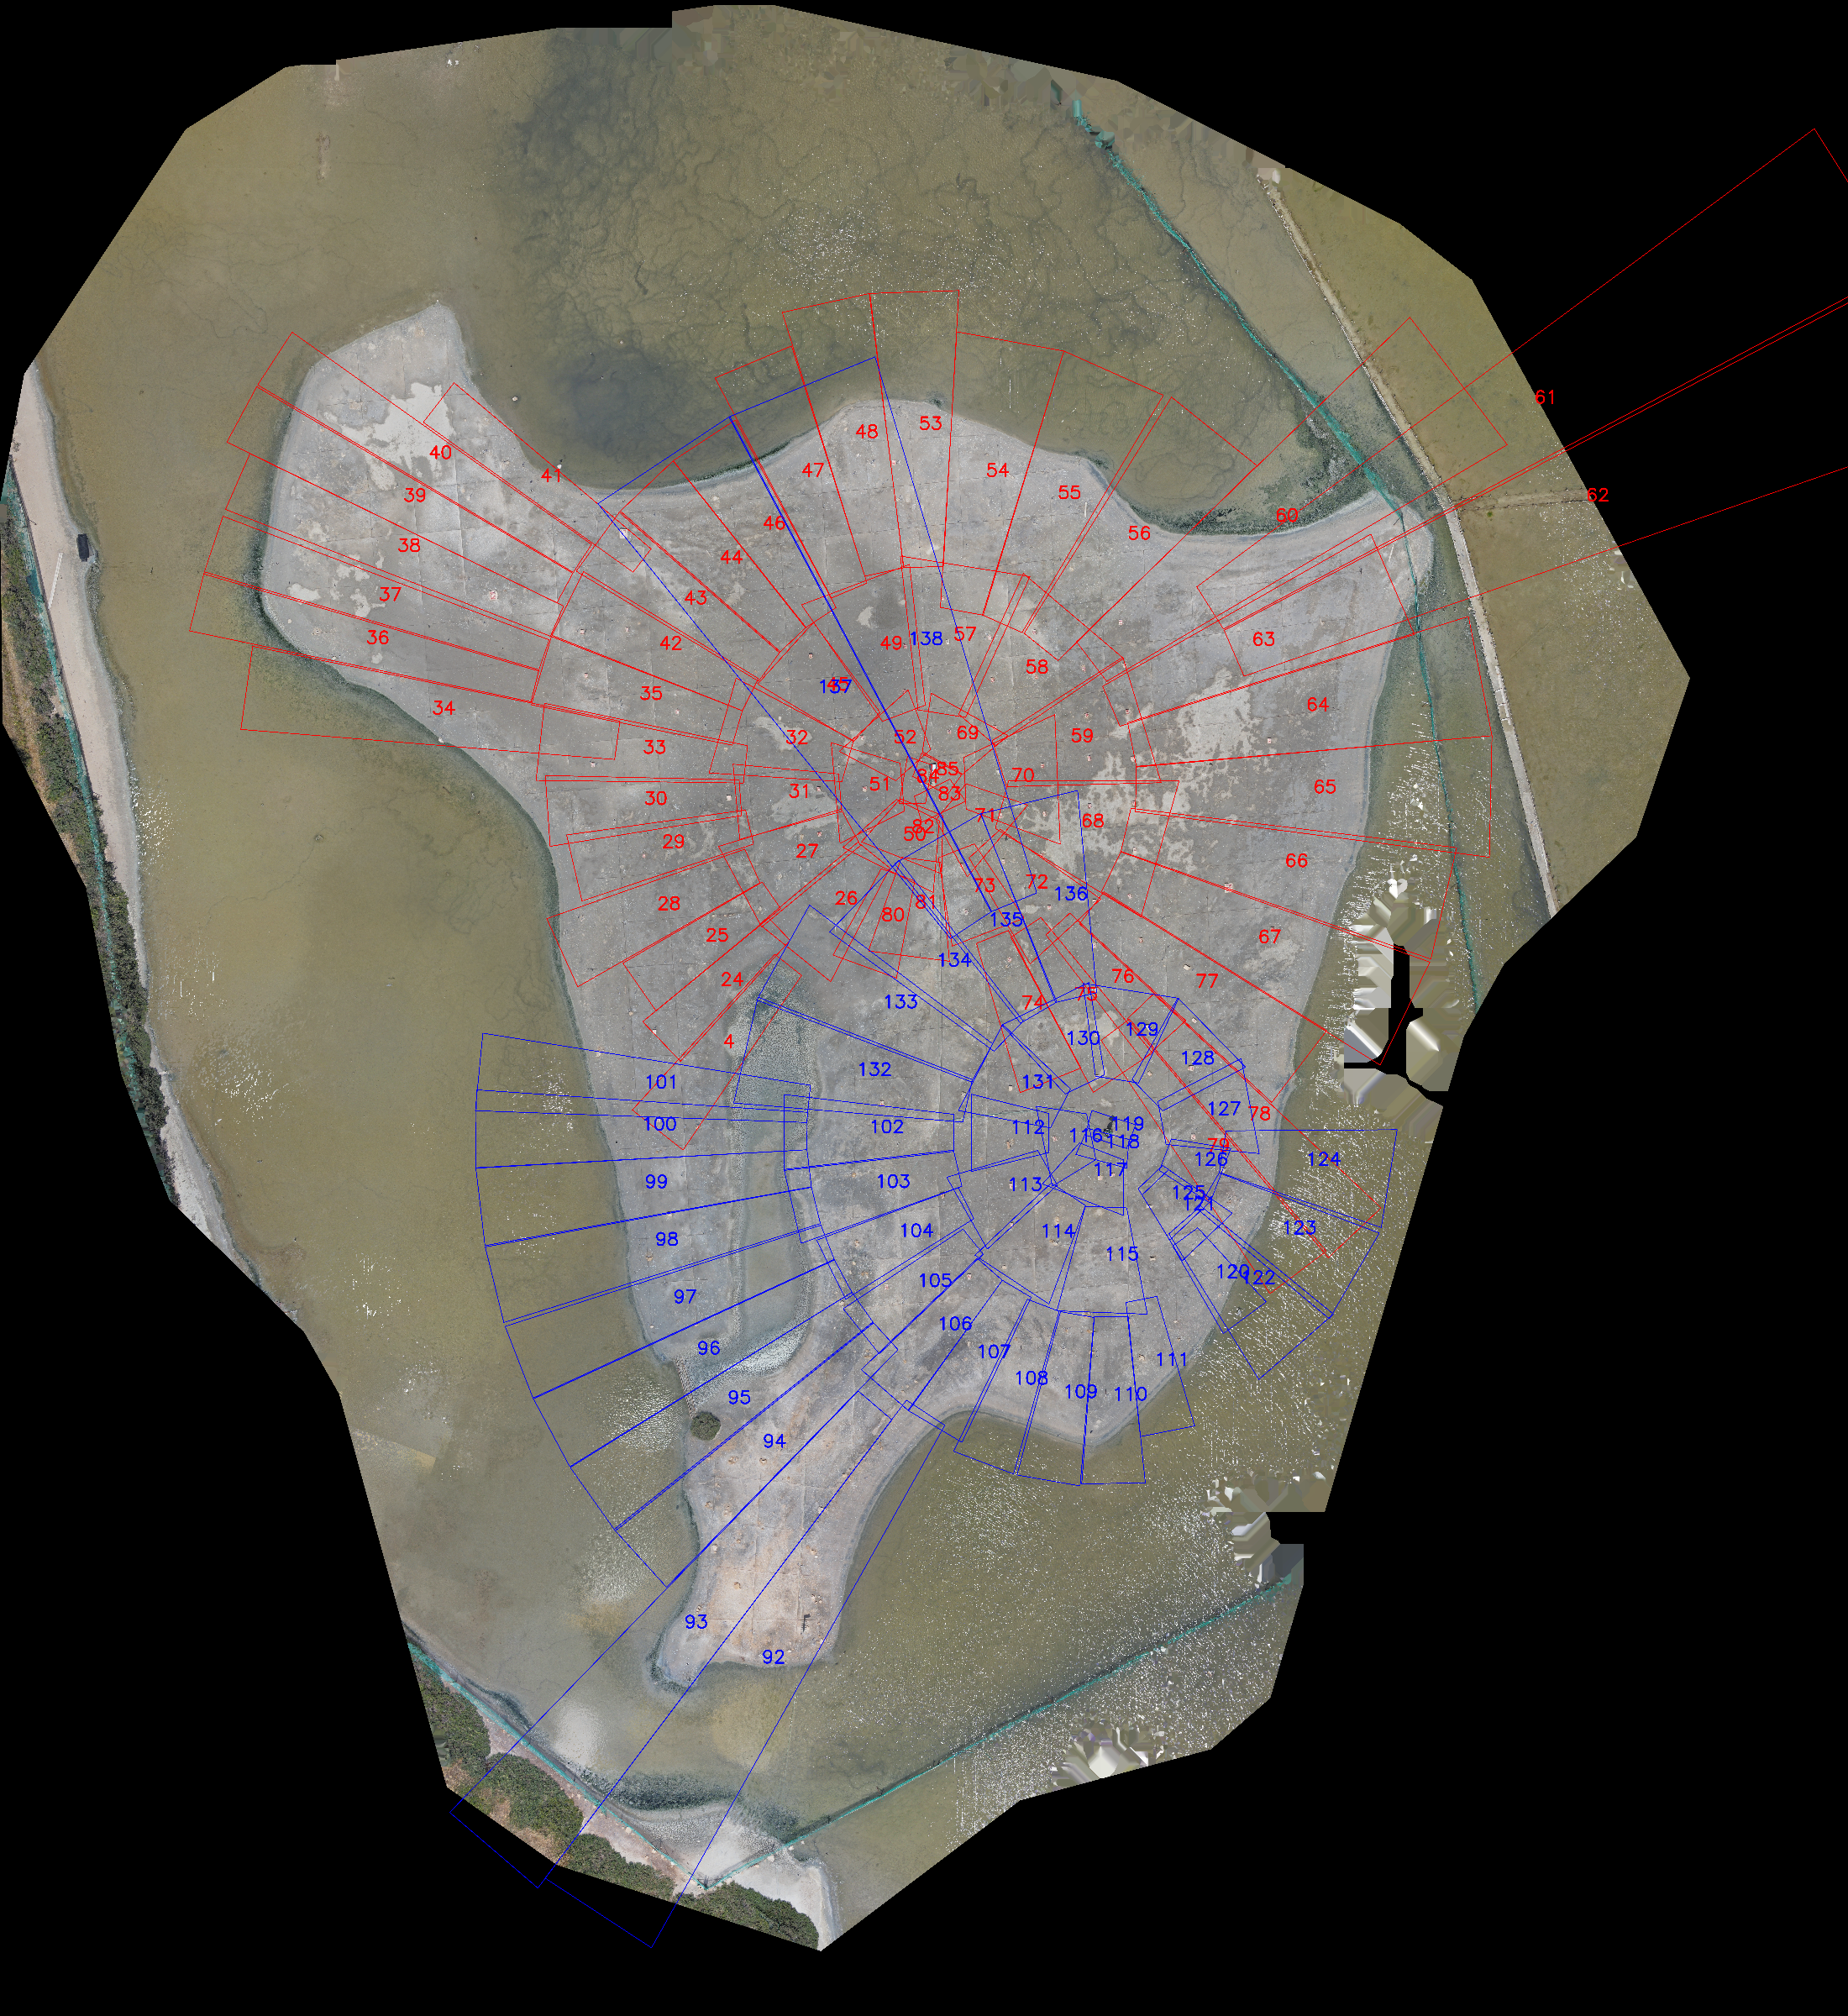

In [ ]:
for index, row in df_ptz_modi_s.iterrows():
      pitch = row['pitch']
      yaw = row['yaw']
      f = row['f']
      ptz_num = row ['ptz_num']
      #print(f"Row {index + 1}: Pitch={pitch}, Yaw={yaw}, f={f}")

      r = R.from_euler('zyx', [yaw, 0, pitch],degrees=True).as_matrix()
      k = make_k(f, center)


      # Create a DataFrame for the four corners of the flag images


      corners_df = pd.DataFrame({
          'Corner': ['Top Left', 'Top Right', 'Bottom Left', 'Bottom Right'],
          'U': [0, image_width - 1, 0, image_width - 1],
          'V': [0, 0, image_height - 1, image_height - 1]
      })

      # calculate the p (the location in cm) for the four corners

      p = calc_p(corners_df,r,k,cam_n)

      ## calculate the corners inpixel of the drone
      corner = corner_loc_pix(s,south_cam_loc, p)


      cv2.polylines(drone_img, [corner], isClosed=True, color=(255, 0, 0), thickness=7)

      number = str(int(ptz_num))
      font = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 7
      font_color = (255, 0, 0)
      font_thickness = 20
      text_size = cv2.getTextSize(number, font, font_scale, font_thickness)[0]
      text_x = (corner[0, 0] + corner[1, 0] + corner [2,0] + corner [3,0]) // 4
      text_y = (corner[0, 1] + corner[1, 1] + corner [2,1] + corner [3,1]) // 4
      cv2.putText(drone_img, number, (text_x, text_y), font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)


scale_factor = 0.1

# Resize the image
resized_image = cv2.resize(drone_img, (0, 0), fx=scale_factor, fy=scale_factor)


cv2_imshow(resized_image)
